**извлечение признаков из текста на естественном языке**

кластеризатор текстов   
  CountVectorizer + KMeans

_Евгений Борисов <esborisov@sevsu.ru>_

## библиотеки

In [1]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm.notebook import tqdm

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

In [2]:
from sklearn import __version__ as SKLEARN_VERSION

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

SKLEARN_VERSION

'1.0.2'

## тексты

In [3]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))

записей: 3196


In [4]:
data.sample(2)

,text,tag
296,"Кинотеатр ""Салют"" установит новый рекорд В кинотеатре ""Салют"" в субботу\n10 декабря стартует фестиваль французских фильмов. Уральцам покажут 5\nфильмов, в том числе новый фильм Франсуа Озона ""Врем...",culture
616,"Когда в паспорте Кошмар и Копец: истории белорусок с необычными фамилиями\n\n5 декабря 2016 в 8:40\n\nЕлена Колосова / Фото из личных архивов героинь\n\nФамилию, как и родственников, не выбирают. ...",woman


## токенизация и очистка

In [5]:
# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
       ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
       ,[r'\w+- ',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()


# разрезаем стоки на слова
def tokenize(s): 
    return [ w for w in s.split(' ') if (len(w)>1)  ]


In [6]:
data['ctext'] = (
    data['text']
    .progress_apply(string_normalizer)
    .progress_apply(tokenize)
    )

  0%|          | 0/3196 [00:00<?, ?it/s]

  0%|          | 0/3196 [00:00<?, ?it/s]

In [7]:
# собираем словарь из текстов
def get_vocabulary(ds):
    vcb = [ set(s) for s in ds.tolist() ]
    return sorted(set.union(*vcb))

In [8]:
vcb0 =  get_vocabulary( data['ctext'] )
print('словарь %i слов'%(len(vcb0)))
# pd.DataFrame( vcb ).to_csv('voc0.txt',index=False,header=False)

словарь 83094 слов


In [9]:
data['ctext'] = data['ctext'].apply(' '.join)

In [10]:
data.sample(10)

,text,tag,ctext
749,Анонимки для милиции: на что жалуются жители Минской области\n\n7 декабря 2016 в 19:35\n\nTUT.BY\n\nСотрудники милиции делятся первыми результатами совместного с «Белпочтой» эксперимента: жителям ...,social,анонимки для милиции на что жалуются жители минской области декабря tut by сотрудники милиции делятся первыми результатами совместного белпочтой эксперимента жителям минской области предложили пис...
243,ЭКЗАМЕН КОМПЬЮТЕРНОЙ ГРАМОТНОСТИ Чиновники Львовского городского совета\nсдадут экзамены на владение компьютером в рамках очередной аттестации.\nОб этом сообщил и.о. городского председателя Львова...,politics,экзамен компьютерной грамотности чиновники львовского городского совета сдадут экзамены на владение компьютером рамках очередной аттестации об этом сообщил городского председателя львова зеновий с...
1787,"В ноябре рост производства стали в Китае ускорился до 5 процентов к АППГ, что стало самым высоким приростом за последние 2,5 года\n\n13 декабря, Пекин. Металлургические предприятия Китайской народ...",economics,ноябре рост производства стали китае ускорился до процентов аппг что стало самым высоким приростом за последние года декабря пекин металлургические предприятия китайской народной республики кнр ув...
2097,"Футболисты киевского клуба «Динамо» и донецкого клуба «Шахтер» устроили драку на поле во время матча чемпионата Украины, об этом сообщает «Спорт-экспресс».\n\nКонфликт произошел в середине второго...",sport,футболисты киевского клуба динамо донецкого клуба шахтер устроили драку на поле во время матча чемпионата украины об этом сообщает спорт-экспресс конфликт произошел середине второго тайма после то...
2500,\r\nФото: Фонтанка.ру\r\n\r\nНа «Ленфильме» представят лучшие исторические книги\r\n\r\nРейтинг:*****\r\n\r\nВыставка исторической литературы появилась в Петербурге в 2015 году и тогда казалась эк...,culture,фото фонтанка ру на ленфильме представят лучшие исторические книги рейтинг выставка исторической литературы появилась петербурге году тогда казалась экспериментом организаторов три десятка издател...
467,"Партия Меркель в преддверии выборов ужесточает миграционную политику\n\n5 декабря 2016 в 23:55\n\nКсения Польская, Deutsche Welle\n\nПеред партийным съездом, который пройдет 6−7 декабря, ХДС соста...",politics,партия меркель преддверии выборов ужесточает миграционную политику декабря ксения польская deutsche welle перед партийным съездом который пройдет декабря хдс составил список более жестких требован...
1406,"Михаил Горбачев в интервью, приуроченном к 25-й годовщине распада СССР, ответил на вопрос, возможно ли его восстановление: «Советского Союза — нет, а Союза — да». «В прежних границах и с тем же со...",politics,михаил горбачев интервью приуроченном годовщине распада ссср ответил на вопрос возможно ли его восстановление советского союза нет союза да прежних границах тем же составом добровольно считаю что ...
2406,"Лучшая драма\n\n«По соображениям совести»\n\n«Любой ценой»\n\n«Лев»\n\n«Манчестер у моря»\n\n«Лунный свет»\n\nВ главной номинации в нынешнем году намечена главная интрига. Во-первых, одним из фаво...",culture,лучшая драма по соображениям совести любой ценой лев манчестер моря лунный свет главной номинации нынешнем году намечена главная интрига во-первых одним из фаворитов глобусов как грядущего оскара ...
1984,"Избранный президент США Дональд Трамп официально объявил о том, что он назначает президента Goldman Sachs Гари Кона главой национального экономического совета.\n\nПресс-релиз опубликован на сайте ...",politics,избранный президент сша дональд трамп официально объявил том что он назначает президента goldman sachs гари кона главой национального экономического совета пресс-релиз опубликован на сайте переход...
1119,"Повторил ""подвиг"" серба, или Как греческий футболист не попал в сетку с линии ворот\n\n6 декабря 2016 в 19:54\n\nSPORT.TUT.BY\n\nВ чемпионате Греции в поединке между «Македоникос Козани» и «Ватеро...",sport,повторил подвиг серба или как греческий 

##  Vectorizer

In [11]:
def tokenizer(s): 
    for w in s.split(' '):
        if (len(w)>1): 
            yield w

X = CountVectorizer(tokenizer=tokenizer, token_pattern=None).fit_transform(data['ctext'])

## кластеризируем

In [12]:
data['cluster'] = KMeans(n_clusters=12).fit(X).labels_
data['cluster'].drop_duplicates().count()

12

## тестируем

In [13]:
# номер кластера, количество объектов, метки объектов
# (cluster=-1 - некластеризованные DBSCAN объекты)
cluster_descr = pd.concat([
        data[['cluster','tag']].groupby(['cluster'])['tag'].count(),
        data[['cluster','tag']].groupby(['cluster'])['tag'].apply(lambda s: set(s)).apply(' '.join)
    ],axis=1).reset_index()

cluster_descr.columns = ['cluster','count','tags']

cluster_descr

,cluster,count,tags
0,0,3,reclama economics
1,1,167,politics realty reclama tech auto woman science culture social sport incident economics
2,2,5,realty economics auto
3,3,781,politics realty reclama tech auto woman science culture social sport incident economics
4,4,50,politics realty reclama tech auto woman science culture social sport incident economics
5,5,2059,politics realty reclama tech health auto woman science culture social sport incident economics
6,6,19,auto woman culture social sport economics
7,7,97,politics realty reclama tech auto woman culture social sport incident economics
8,8,4,woman economics
9,9,6,woman sport auto


<AxesSubplot:xlabel='cluster'>

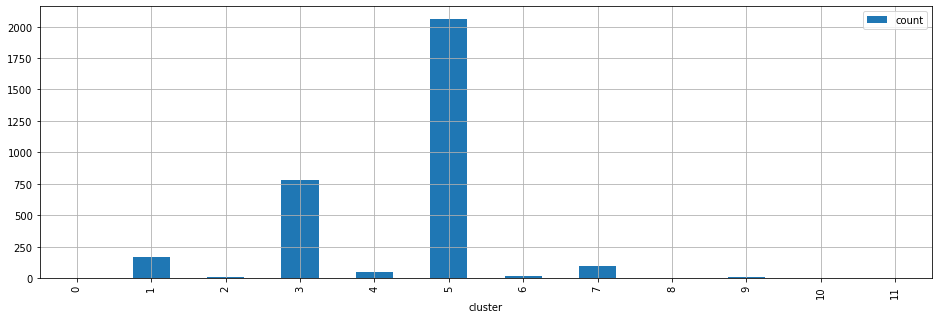

In [14]:
# размеры кластеров
cluster_descr[['cluster','count']]\
    .query('cluster>-1')\
    .set_index('cluster')\
    .plot.bar(grid=True,figsize=(16,5))

In [15]:
def print_cluster_samples(n,ns=3,nt=300):
    count,tags = cluster_descr.query(f'cluster=={n}')[['count','tags']].values[0]#.tolist
    df = data.query(f'cluster=={n}')
    ns_ = min(ns,len(df))
    top = [ t[:nt].replace('\n',' ') for t in df['text'].sample(ns_).values ]
    print('[ КЛАСТЕР %i, элементов: %i, метки: "%s" ]'%(n,count,tags))
    for s in top: print('\n%s ...\n'%(s) )

In [16]:
for n in rng.permutation(cluster_descr['cluster'].max())[:3] :
    print_cluster_samples(n)
    print('\n= = = = = = = = = = = = = = = = = = = = = = = = = =\n')

[ КЛАСТЕР 7, элементов: 97, метки: "politics realty reclama tech auto woman culture social sport incident economics" ]

Тренды маркетинга 2017  6 декабря 2016 в 9:00  *На правах рекламы  Будущее наступает быстрее, чем завтра.  Если перечитать эту фразу больше 3 раз, начинают шевелиться волосы на голове. Оно реально наступает стремительнее, чем мы успеваем заметить! Как успевать ловить все изменения, тенденции, иннова ...


Латвийские банки закрывают счета нерезидентов  9 декабря 2016 в 8:32  Русская служба Би-би-си  С начала года объем вкладов в латвийских банках нерезидентов, среди которых, как считается, значительную долю составляют российские физические и юридические лица, сократился на 20%, говорят в Ассоциации ко ...


Как правильно питаться зимой: 6 работающих советов  7 декабря 2016 в 9:50  kitchenmag.ru  Зима — время проверки на прочность: холод и темные дни так и тянут нас сойти с пути правильного питания в сторону полок со сладостями, булочками и вареньем.  Мы часто мерзнем, 